In [2]:
import numpy as np
import plotly.graph_objects as go
import plotly.colors as pc
from scipy.integrate import quad 

# Решаем задачу
$$
\begin{cases}
u_t = u_{xx} + bu, \quad b = const > 0, x \in (0, 1) \\
u(t, 0) = u (t, 1) = 0 \\
u(0, x) = \text{sin}(\pi x)
\end{cases}
$$
Оно имеет решение $u(t, x) = e^{-t(\pi^2 - b)}sin(\pi x)$

Схема:
$$
\begin{cases}
\frac{u_m^{n+1} - u_m^{n}}{\tau} = \frac{u_{m+1}^{n+1} - 2 u_{m}^{n+1} + u_{m-1}^{n+1}}{h^2} + b u_m^{n+1} \\
u_0^n = u_{M}^n = 0 \\
u_m^0 = \text{sin}(\pi x_m)
\end{cases}
$$

In [13]:
T = 1
N = 10
M = 10
x_min = 0
x_max = 1

b = 10.

def f_0(x):
    return np.sin(np.pi * x) * (x <= 1)
def exact_solution(t, x):
    if isinstance(t, float):
        return np.exp(-(np.pi ** 2 - b) * t) * np.sin(np.pi * x)
    return np.exp(-(np.pi ** 2 - b) * t[:, None]) * np.sin(np.pi * x[None, :])

h = (x_max - x_min) / M
x = np.linspace(x_min, x_max, M + 1)

tau = T / N

u_t_x = np.zeros(shape = (N + 1, M + 1))
u_t_x[0, :] = exact_solution(0., x) # 

for i in range(1, N + 1):
    T_prev = u_t_x[i - 1, :]
    main_diag_value = 1 / tau - b + 2 / (h ** 2)
    off_diag_value = -1 / (h ** 2)
    main_diag = np.full(M - 1, main_diag_value)
    off_diag = np.full(M - 2, off_diag_value)
    A = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    f_t_x = 1 / tau * T_prev
    u_t_x[i, 1:-1] = np.linalg.solve(A, f_t_x[1:-1])


Решения растут по времени:

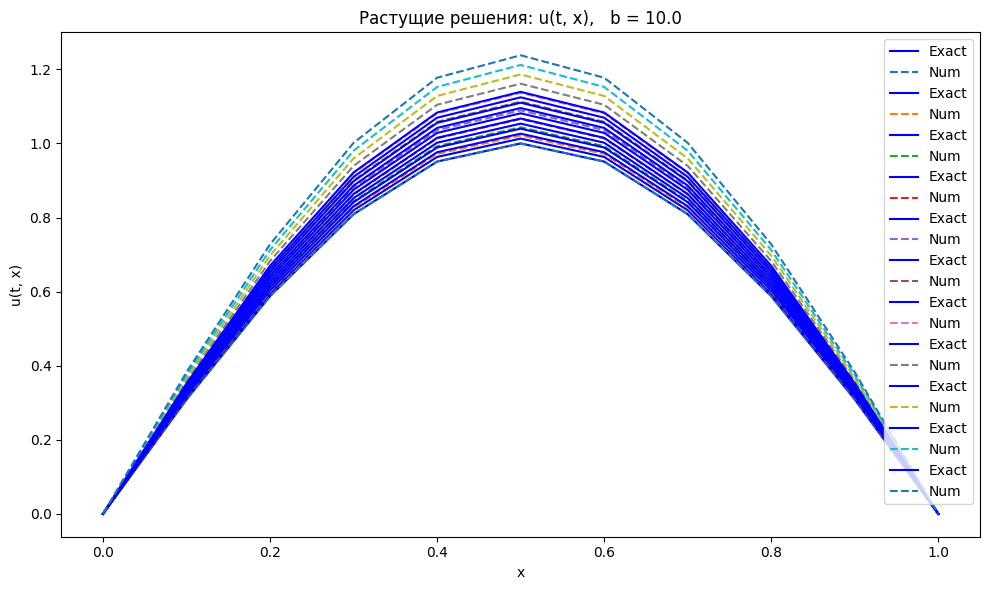

In [14]:
# График точное, численное для разных t
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for i in range(N + 1):
    t = tau * i
    # Plot the exact solution
    plt.plot(x, exact_solution(t, x), label="Exact", color="blue")
    # Plot the numerical solution
    plt.plot(x, u_t_x[i, :], label=f"Num", linestyle='--')

# Add title and labels
plt.title(f"Растущие решения: u(t, x),   b = {b}")
plt.xlabel("x")
plt.ylabel("u(t, x)")

# Configure legend
plt.legend(loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Это проблема, поэтому вводится задача управления граничным условием так, чтобы решение не росло по t:
$$
\begin{cases}
v_t = v_{xx} + bv, \quad b = const > 0, x \in (0, 1) \\
v(t, 0) = 0 \\
v(t, 1) = \mu (t) \\
v(0, x) = \text{sin}(\pi x) \\
||v(t)|| \to 0, t \to \infty
\end{cases}
$$

Искать это $\mu(t)$ явно трудно, поэтому решаем задачу на расширенном отрезке [0, 2]:
$$
\begin{cases}
w_t = w_{xx} + bw, \quad b = const > 0, x \in (0, 2) \\
w(t, 0) = w (t, 2) = 0 \\
w(0, x) = \begin{cases} 
            \text{sin}(\pi x)&, \quad x \in [0, 1] \\
            \dots&, \quad x \in (1, 2]
          \end{cases}\\
||w(t)|| \to 0, \quad  t \to \infty
\end{cases}
$$
Решение задачи имеет вид $w(t, x) = \sum_{k = 1}^\infty C_k(t) \text{sin}(\frac{\pi k x}{2}), \quad C_k(t) = e^{(-\pi^2 k^2 / 4 + b)t}$, которое не растет, если равны нулю первые несколько слагаемых, где $b > \pi^2 k^2 / 4$. 

Для b = 10 нужно обнулить первые два слагаемых. Для этого ищем начальное условие в виде:
$$
w^0(x) = w^0_{[0, 1]}(x) + c_1 e_1(x) + c_2 e_2(x)
$$
Здесь 
$$
w^0_{[0, 1]}(x) = \begin{cases} \text{sin} \pi x, \quad x \in [0, 1] \\ 0, \quad x \in [1, 2] \end{cases} \\
e_k(x) = \begin{cases} 0&, \quad x \in [0, 1] \\ \text{sin} \frac{\pi kx}{2}&, \quad x \in [1, 2] \end{cases} \\

$$
А $c_1, c_2$ ищутся из условия:
$$
(w^0(x), \sin \frac{\pi x}{2}) = (w^0(x), \sin \pi x) = 0 
$$


Убедимся, что для k > 2 коэффициент при t отрицательный, и экспонента не возрастает по t:

Ищем $w^0(x)$ из системы:
$$
\begin{cases}
c_1 (e_1, \sin \frac{\pi x}{2}) + c_2 (e_2, \sin \frac{\pi x}{2}) = -(w^0_{[0, 1]}, \sin \frac{\pi x}{2})\\
c_1 (e_1, \sin \frac{2 \pi x}{2}) + c_2 (e_2, \sin \frac{2 \pi x}{2}) = -(w^0_{[0, 1]}, \sin \frac{2 \pi x}{2})
\end{cases}
$$

In [ ]:
x_min = 0
x_max = 2

w_01 = lambda x: np.sin(np.pi * x) * (x >= 0) * (x <= 1)

e_1 = lambda x: np.sin(np.pi * x / 2) * (x >= 1) * (x <= 2)
e_2 = lambda x: np.sin(np.pi * x) * (x >= 1) * (x <= 2)
sin_pi_x_2 = lambda x: np.sin(np.pi * x / 2)
sin_pi_x = lambda x: np.sin(np.pi * x)
def scalar_prod(f, g, a = x_min, b = x_max):
    return quad(lambda x: f(x) * g(x), a, b)[0]

Matrix = np.array([[scalar_prod(e_1, sin_pi_x_2), scalar_prod(e_2, sin_pi_x_2)],
              [scalar_prod(e_1, sin_pi_x), scalar_prod(e_2, sin_pi_x)]])
f = -np.array([scalar_prod(w_01, sin_pi_x_2), scalar_prod(w_01, sin_pi_x)])
print("Matrix: ", Matrix)
print("f: ", f)
c1, c2 = np.linalg.solve(Matrix, f)

print(f"c_1 = {c1}, c_2 = {c2}")

Matrix:  [[ 0.5        -0.42441318]
 [-0.42441318  0.5       ]]
f:  [-0.42441318 -0.5       ]
c_1 = -6.07402630994896, c_2 = -6.155793662392542


In [27]:
x_min = 0
x_max = 3

w_01 = lambda x: 5 * (x**2) * np.sin(np.pi * x) * (x >= 0) * (x <= 1)

# e_1 = lambda x: np.sin(np.pi * x / 2) * (x >= 1) * (x <= 2)
# e_2 = lambda x: np.sin(np.pi * x) * (x >= 1) * (x <= 2)
# sin_pi_x_2 = lambda x: np.sin(np.pi * x / 2)
# sin_pi_x = lambda x: np.sin(np.pi * x)

e_1 = lambda x: np.sin(np.pi * x / 3) * (x >= 1) * (x <= 3)
e_2 = lambda x: np.sin(2 * np.pi * x / 3) * (x >= 1) * (x <= 3)
e_3 = lambda x: np.sin(np.pi * x) * (x >= 1) * (x <= 3)
sin_pi_x_3 = lambda x: np.sin(np.pi * x / 3)
sin_pi_x_23 = lambda x: np.sin(2* np.pi * x / 3)
sin_pi_x = lambda x: np.sin(np.pi * x)

def scalar_prod(f, g, a = x_min, b = x_max):
    return quad(lambda x: f(x) * g(x), a, b)[0]

Matrix = np.array([[scalar_prod(e_1, sin_pi_x_3), scalar_prod(e_2, sin_pi_x_3), scalar_prod(e_3, sin_pi_x_3)],
              [scalar_prod(e_1, sin_pi_x_23), scalar_prod(e_2, sin_pi_x_23), scalar_prod(e_3, sin_pi_x_23)],
              [scalar_prod(e_1, sin_pi_x), scalar_prod(e_2, sin_pi_x), scalar_prod(e_3, sin_pi_x)]])
f = -np.array([scalar_prod(w_01, sin_pi_x_3), scalar_prod(w_01, sin_pi_x_23), scalar_prod(w_01, sin_pi_x)])
print("Matrix: ", Matrix)
print("f: ", f)
c1, c2, c3 = np.linalg.solve(Matrix, f)

print(f"c_1 = {c1}, c_2 = {c2}, c_3 = {c3}")

Matrix:  [[ 1.20674834 -0.41349667 -0.3101225 ]
 [-0.41349667  0.89662583 -0.49619601]
 [-0.3101225  -0.49619601  1.        ]]
f:  [-0.59291788 -0.868715   -0.70668185]
c_1 = -3.04690987378974, c_2 = -4.532669752590974, c_3 = -3.900689799518202


In [28]:
w0 = lambda x: w_01(x) + c1 * e_1(x) + c2 * e_2(x) + c3*e_3(x)

Схема:
$$
\begin{cases}
\frac{w_m^{n+1} - w_m^{n}}{\tau} = \frac{w_{m+1}^{n+1} - 2 w_{m}^{n+1} + w_{m-1}^{n+1}}{h^2} + b w_m^{n+1} \\
w_0^n = w_{M}^n = 0 \\
w_m^0 = w^0(x_m)
\end{cases}
$$

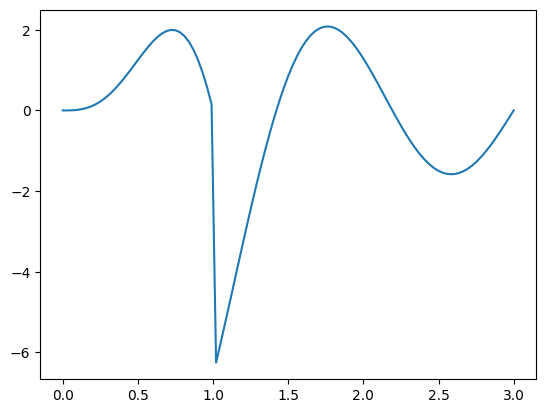

In [34]:
plt.plot(x, w0(x))

In [32]:
T = 0.1
N = 10
M = 100
x_min = 0
x_max = 3

b = 10.

def w_0(x):
    return w_01(x) + c1 * e_1(x) + c2 * e_2(x)

h = (x_max - x_min) / M
x = np.linspace(x_min, x_max, M + 1)

tau = T / N

u_t_x = np.zeros(shape = (N + 1, M + 1))
u_t_x[0, :] = w_0(x)

for i in range(1, N + 1):
    T_prev = u_t_x[i - 1, :]

    main_diag_value = 1 / tau - b + 2 / (h ** 2)
    off_diag_value = -1 / (h ** 2)

    main_diag = np.full(M - 1, main_diag_value)
    off_diag = np.full(M - 2, off_diag_value)

    A = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)

    f_t_x = 1 / tau * T_prev
    u_t_x[i, 1:-1] = np.linalg.solve(A, f_t_x[1: -1])


IndexError: index 0 is out of bounds for axis 0 with size 0

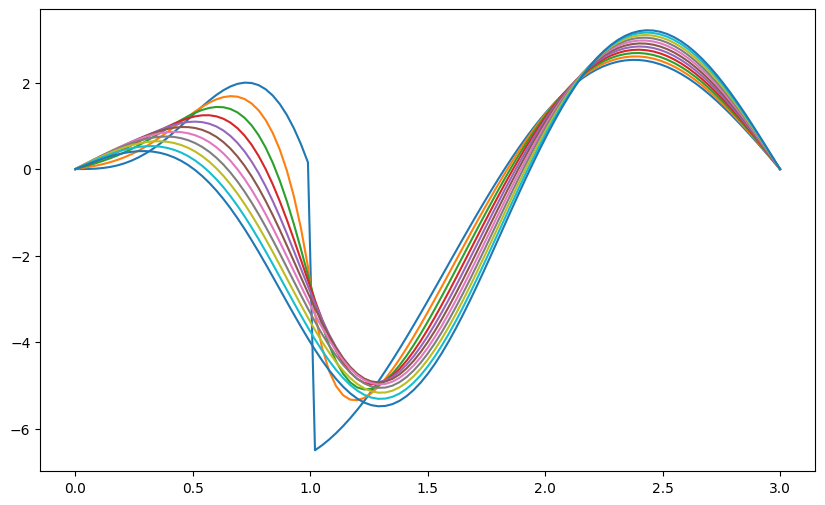

In [33]:
plt.figure(figsize=(10, 6))

# Plot each line for the range N+1
for i in range(N + 1):
    t = tau * i
    plt.plot(x, u_t_x[i, :], label=f"Num, t = {t:.2f}" if i < 1 else "")

# Find the index `i_0` where x == 1
i_0 = np.where(x == 1)[0][0]
print(i_0)

# Plot the markers using `plt.scatter`
plt.scatter(np.ones(N + 1), u_t_x[:, i_0], label="mu(t)", color="red")

# Add a vertical line at x = 1
plt.axvline(x=1, linestyle='--', color='grey', linewidth=1)

# Add title and labels
plt.title(f"Теперь не растущие решения: w(t, x),   b = {b}")
plt.xlabel("x")
plt.ylabel("w(t, x)")

# Configure legend
plt.legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()